<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Машинное обучение и майнинг данных"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# Занятие 6. Задача восстановления регрессии. Обучение без учителя

## Часть 2. Lasso и Ridge регрессия

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
# import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge

Populating the interactive namespace from numpy and matplotlib


**Будем работать с набором данных по ценам на дома в Бостоне (репозиторий UCI).**
**Загружаем данные.**

In [2]:
boston = load_boston()
X, y = boston['data'], boston['target']

**Почитаем описание набора данных:**

In [3]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

**Признаки:**
- CRIM - количество преступлений на душу населения
- ZN - процент жилых участков площадью больше 25 тыс. кв. футов (~ 23 сотки)
- INDUS - процент площадей под оптовую торговлю 
- CHAS - протекает ли река
- NOX - концентрация оксидов азота
- RM - среднее число комнат в здании
- AGE - доля зданий, построенных до 1940 года 
- DIS - взвешенное расстояние до 5 деловых центров Бостона
- RAD - индекс доступности скоростных магистралей
- TAX - уровень налогов
- PTRATIO - среднее число учащихся на одного преподавателя 
- B - процент афроамериканцев
- LSTAT - процент граждан с низким уровнем жизни
- MEDV (целевой) - медианная стоимости домов в районе

In [4]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], 
      dtype='|S7')

**Посмотрим на первые 2 записи.**

In [5]:
X[:2]

array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00,
          0.00000000e+00,   5.38000000e-01,   6.57500000e+00,
          6.52000000e+01,   4.09000000e+00,   1.00000000e+00,
          2.96000000e+02,   1.53000000e+01,   3.96900000e+02,
          4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00,
          0.00000000e+00,   4.69000000e-01,   6.42100000e+00,
          7.89000000e+01,   4.96710000e+00,   2.00000000e+00,
          2.42000000e+02,   1.78000000e+01,   3.96900000e+02,
          9.14000000e+00]])

## Lasso-регрессия

Lasso-регрессия решает задачу минимизации среднеквардатичной ошибки с L1-регуляризацией:
$$error(X, y, \beta) = \frac{1}{2n} \sum_{i=1}^n {(y_i - \beta^Tx_i)}^2 + \alpha \sum_{i=1}^n |\beta_i|$$

где $y = \beta^Tx$ - уравнение гиперплоскости, зависящее от параметров модели $\beta$, $n$-число объектов в выборке X, y - значения целевого признака, $\alpha$ - коэффициент регуляризации.

**Обучим Lasso-регрессию с небольшим коэффициентом $\alpha$ (слабая регуляризация). Обнуляется только коэффициент при признаке NOX (концентрация оксидов азота). Значит, он наименее важен для предсказания целевого признака - медианной стоимости домов в районе.**

In [5]:
lasso = Lasso(alpha=0.1)
lasso.fit(X,y)
lasso.coef_

array([-0.09678792,  0.04917922, -0.03642541,  0.95709698, -0.        ,
        3.69894259, -0.01000634, -1.16012114,  0.27411189, -0.01456675,
       -0.77100252,  0.01032665, -0.56950927])

**Обучим Lasso-регрессию с коэффициентом $\alpha=10$. Теперь ненулевые коэффициенты остались только при признаках ZN (процент жилых участков площадью больше 25 тыс. кв. футов), TAX (уровень налогов), B (процент афроамериканцев) и LSTAT (процент граждан с низким уровнем жизни).**

In [7]:
lasso = Lasso(alpha=10)
lasso.fit(X,y)
lasso.coef_

array([-0.        ,  0.02614601, -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.00928243,
       -0.        ,  0.00749584, -0.56403798])

**Таким образом, Lasso-регрессия служит методом отбора признаков.**

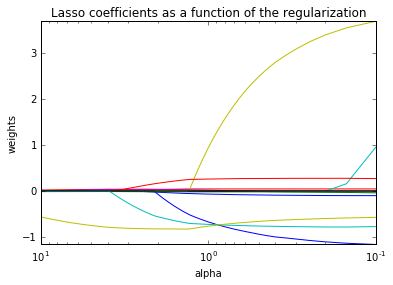

In [8]:
n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)
model = Lasso()

coefs = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(X, y)
    coefs.append(model.coef_)
    
ax = plt.gca()
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

**Теперь определим лучшее значение $\alpha$ в процессе кросс-валидации.**

In [9]:
lasso_cv = LassoCV(alphas=alphas, 
                   cv=3, random_state=42)
lasso_cv.fit(X, y)

LassoCV(alphas=array([  0.1    ,   0.14975, ...,   9.95025,  10.     ]),
    copy_X=True, cv=3, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False)

In [10]:
lasso_cv.coef_

array([-0.09633634,  0.04943349, -0.02730583,  0.16245012, -0.        ,
        3.55546459, -0.00723939, -1.13353947,  0.28039514, -0.0150312 ,
       -0.78020119,  0.01032709, -0.58332373])

In [11]:
lasso_cv.alpha_

0.14974874371859298

**В Scikit-learn версии 0.17 все еще не исправлен [баг](https://github.com/scikit-learn/scikit-learn/issues/2439): cross_val_score может возвращать отрицательные значения RMSE. В любом случае, можно смотреть на модуль ошибки - чем меньше, тем лучше.**

In [12]:
cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=3, scoring='mean_squared_error')

array([-16.90196564, -37.60029071, -72.42092752])

In [13]:
abs(np.mean(cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=3, 
                        scoring='mean_squared_error')))

42.307727953439247

In [14]:
abs(np.mean(cross_val_score(Lasso(9.95), X, y, cv=3 , scoring='mean_squared_error')))

53.722668480656033

**Еще один неоднозначный момент: LassoCV сортирует значения параметров по убыванию - так проще оптимизировать. Из-за этого может показаться, что оптимизация параметра $\alpha$ работает неправильно**

In [15]:
lasso_cv.alphas[:10] # значения параметров на входе

array([ 0.1       ,  0.14974874,  0.19949749,  0.24924623,  0.29899497,
        0.34874372,  0.39849246,  0.44824121,  0.49798995,  0.54773869])

In [16]:
lasso_cv.alphas_[:10] # преобразованные значения параметров

array([ 10.        ,   9.95025126,   9.90050251,   9.85075377,
         9.80100503,   9.75125628,   9.70150754,   9.65175879,
         9.60201005,   9.55226131])

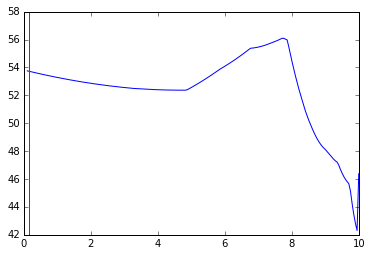

In [17]:
plot(lasso_cv.alphas, lasso_cv.mse_path_.mean(1)) # неверно
axvline(lasso_cv.alpha_, c='g')

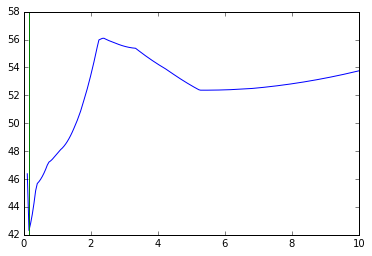

In [18]:
plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(1)) # верно
axvline(lasso_cv.alpha_, c='g')

## Ridge-регрессия

Ridge-регрессия (или гребневая регрессия) решает задачу минимизации среднеквардатичной ошибки с L2-регуляризацией:
$$error(X, y, \beta) = \frac{1}{2n} \sum_{i=1}^n {(y_i - \beta^Tx_i)}^2 + \alpha \sum_{i=1}^n \beta_i^2$$

где $y = \beta^Tx$ - уравнение гиперплоскости, зависящее от параметров модели $\beta$, $n$-число объектов в выборке X, y - значения целевого признака, $\alpha$ - коэффициент регуляризации.

В sklearn реализован специальный класс [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) для кросс-валидации с Ridge-регрессией.

In [19]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

In [20]:
ridge_cv = RidgeCV(alphas=ridge_alphas, 
                   scoring='mean_squared_error',
                   cv=3)
ridge_cv.fit(X, y)

RidgeCV(alphas=array([  1.00000e-02,   1.09699e-02, ...,   9.11589e+05,   1.00000e+06]),
    cv=3, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='mean_squared_error', store_cv_values=False)

In [21]:
ridge_cv.alpha_

289.94228538828753

**В случае Ridge-регрессии никакие праметры не зануляются - они могут быть очень малыми, но не нулевыми.**

In [22]:
ridge_cv.coef_

array([-0.09886918,  0.05558896, -0.04913076,  0.28028401, -0.08231017,
        1.34294878,  0.01415244, -0.97706352,  0.33105061, -0.01666047,
       -0.8155142 ,  0.00877687, -0.72870176])

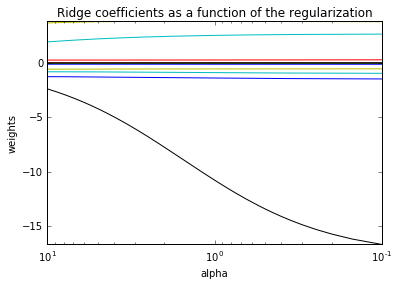

In [23]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)
model = Ridge()

coefs = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(X, y)
    coefs.append(model.coef_)
    
ax = plt.gca()
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

## Ссылки
- [Обощеннные линейные модели](http://scikit-learn.org/stable/modules/linear_model.html) (Generalized Linear Models, GLM) в Scikit-learn
- [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression), [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso), [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV), [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) и [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) в Scikit-learn
- [Статья](https://habrahabr.ru/post/264915/) "Методы отбора фич" на Хабрахабре с упоминанием Lasso-регрессии 